# Model Selection

- With the SMOTE oversampled dataset I test out the performance of six supervised ML models: KNN, Decision Tree, Random Forest, XGBoost, Logistic Regression and MLP at classifying the 10 different cell types
- RandomizedSearchCV with 100 iterations and 3-fold cross validation is used to tune the hyperparameters of each model
- The best performing model (based on the testing dataset) will be used for subsequent feature selection in notebook 3 (Feature_Importance.ipynb)

In [1]:
#load libraries
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
import imblearn
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from numpy import mean
import pandas as pd
import scipy.stats
import xgboost as xgb
import warnings


#custom display options
warnings.filterwarnings('ignore')
mpl.rcParams['figure.dpi'] = 150
pd.set_option('display.max_rows', 50)

/.mounts/labs/reimandlab/private/users/mslobodyanyuk/anaconda3/envs/myenv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Lets load the training and testing data that was acquired from the "Class_Imbalance.ipynb" notebook. 

In [2]:
X_train = pd.read_csv("~/scRNA_seq_project/X_train.csv",sep=",", header=0, index_col=0)
Y_train = pd.read_csv("~/scRNA_seq_project/Y_train.csv",sep=",", header=0, index_col=0).cls_id
X_test = pd.read_csv("~/scRNA_seq_project/X_test.csv",sep=",", header=0, index_col=0)
Y_test = pd.read_csv("~/scRNA_seq_project/Y_test.csv",sep=",", header=0, index_col=0).cls_id

display(X_train)
display(Y_train)

,ENSG00000163736,ENSG00000254709,ENSG00000163737,ENSG00000127920,ENSG00000120885,ENSG00000168497,ENSG00000143546,ENSG00000163220,ENSG00000115523,ENSG00000132465,...,ENSG00000128274,ENSG00000130429,ENSG00000133401,ENSG00000124302,ENSG00000167522,ENSG00000148834,ENSG00000246379,ENSG00000148655,ENSG00000166707,ENSG00000142937
51889,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
13786,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
16764,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
35962,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31618,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
51102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5911,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
36867,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


51889                       Dendritic
13786    CD8+/CD45RA+ Naive Cytotoxic
1404              CD4+/CD45RO+ Memory
16764                 CD4+/CD25 T Reg
35962    CD8+/CD45RA+ Naive Cytotoxic
                     ...             
31618                CD8+ Cytotoxic T
51102                 CD4+/CD25 T Reg
5911                  CD4+/CD25 T Reg
36867             CD4+/CD45RO+ Memory
11429                CD8+ Cytotoxic T
Name: cls_id, Length: 54848, dtype: object

## Three Functions To:
- Evaluate the performance of each model on the testing data using the predicted cell labels
- Rename the classifier hyperparameters from the imblearn pipeline by removing the 'model__' string
- Plot the confusion matrix of each optimized model

In [3]:
def model_performance(model, X_train, Y_train, X_test,Y_test):
    performance = {'f1_macro' : [], 'precision_macro' : [], 'recall_macro' : [], 'accuracy' : [], 'AUROC_macro' : []}
    model.fit(X_train,Y_train)
    model_pred = model.predict(X_test)
    performance["precision_macro"].append(precision_score(Y_test, model_pred, average="macro"))
    performance["recall_macro"].append(recall_score(Y_test, model_pred, average="macro"))
    performance["f1_macro"].append(f1_score(Y_test, model_pred, average="macro"))
    performance["accuracy"].append(accuracy_score(Y_test, model_pred))
    performance["AUROC_macro"].append(roc_auc_score(Y_test,model.predict_proba(X_test), multi_class = "ovr", average="macro"))
    return [pd.DataFrame(performance), pd.DataFrame(model_pred)]

In [4]:
def convert_parameters(smote_parameters):
    renamed_parameters = {}
    for k,v in smote_parameters.items():
        renamed_parameters[k[7:]] = v
    return renamed_parameters

In [5]:
def confusion_mtx_plotter(predicted_cells,classification_model):
    matrix = confusion_matrix(Y_test,predicted_cells, labels=np.unique(Y_test))
    matrix = matrix/matrix.sum(axis=1, keepdims=True)*1
    df_matrix = pd.DataFrame(matrix)
    df_matrix.columns = np.unique(Y_test)
    df_matrix.index = np.unique(Y_test)

    sns.set(font_scale=0.85)
    ax = sns.heatmap(df_matrix,cmap ="YlGnBu",annot = True,vmin = 0, vmax = 1,linewidth=0.5,annot_kws={"size": 7})
    ax.set_title(classification_model, fontdict={'fontsize':12}, pad=12)
    plt.show()
    vis = ax.get_figure()
    vis.savefig(classification_model + '_confusionmtx.pdf', bbox_inches='tight')

## KNN

In [6]:
knn_grid = {'model__n_neighbors': [1,3,5,10,20,100],
            'model__weights': ["uniform", "distance"],
            'model__algorithm': ["auto", "ball_tree", "kd_tree", "brute"],
            'model__p': [1,2],
            'model__metric': ["euclidean","manhattan", "chebyshev", "minkowski", "wminkowski"]}

knn_steps = [('over', SMOTE()), ('model', KNeighborsClassifier())]
knn_pipeline = Pipeline(steps=knn_steps)

knn_variants = RandomizedSearchCV(estimator = knn_pipeline, param_distributions = knn_grid, n_iter = 100, cv = 3, random_state=42, n_jobs = -1)
knn_variants.fit(X_train,Y_train)
knn_best_params = knn_variants.best_params_
print(knn_best_params)

{'model__weights': 'distance', 'model__p': 1, 'model__n_neighbors': 100, 'model__metric': 'minkowski', 'model__algorithm': 'auto'}


In [7]:
#remove the model__ portion of the parameter name
renamed_knn_best_parameters = convert_parameters(knn_best_params)
print(renamed_knn_best_parameters)

#evaluate the performance of the baseline and optimized model
knn_baseline = model_performance(knn_pipeline,X_train, Y_train, X_test,Y_test)[0]
knn_optimized,knn_pred = model_performance(Pipeline(steps = [('over', SMOTE()), ('model', KNeighborsClassifier(**renamed_knn_best_parameters))]),X_train, Y_train, X_test,Y_test)

knn_performance = pd.concat([knn_baseline,knn_optimized], axis = 0,ignore_index = True)
knn_performance = knn_performance.rename(index = {0 : "baseline_KNN", 1 : "optimized_KNN"})
knn_performance

{'weights': 'distance', 'p': 1, 'n_neighbors': 100, 'metric': 'minkowski', 'algorithm': 'auto'}


,f1_macro,precision_macro,recall_macro,accuracy,AUROC_macro
baseline_KNN,0.592298,0.633946,0.670356,0.499198,0.873965
optimized_KNN,0.644286,0.663485,0.636579,0.663288,0.912891


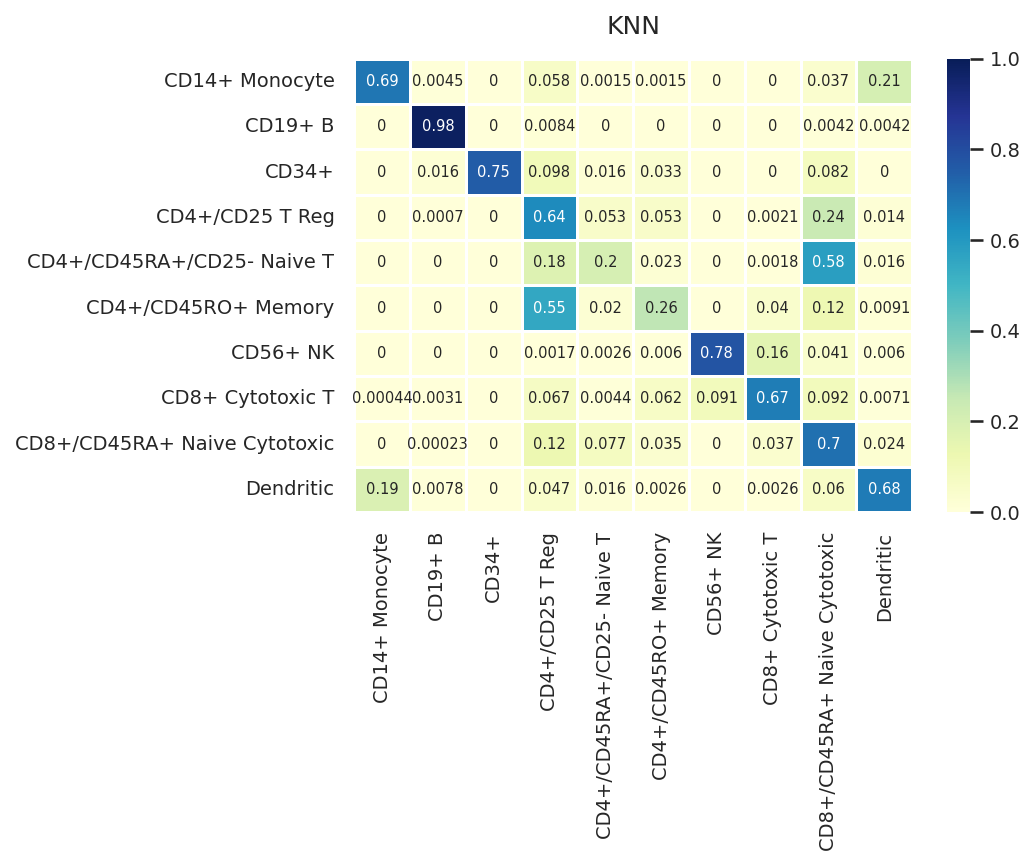

In [8]:
#confusion matrix
knn_confusion_mtx = confusion_mtx_plotter(knn_pred,"KNN")
knn_confusion_mtx

## Decision Tree 

In [9]:
dt_grid = {'model__criterion': ["gini", "entropy"],
           'model__splitter': ["best", "random"],
           'model__max_features': [None,"sqrt","log2"],
           'model__max_depth': [None,5,10,50,100],
           'model__min_samples_split': [2, 5, 10],
           'model__min_samples_leaf' : [1,2,5]}

dt_steps = [('over', SMOTE()), ('model', DecisionTreeClassifier())]
dt_pipeline = Pipeline(steps=dt_steps)

dt_variants = RandomizedSearchCV(estimator = dt_pipeline, param_distributions = dt_grid, n_iter = 100, cv = 3,random_state=42, n_jobs = -1)
dt_variants.fit(X_train,Y_train)
dt_best_params = dt_variants.best_params_
print(dt_best_params)

{'model__splitter': 'best', 'model__min_samples_split': 5, 'model__min_samples_leaf': 5, 'model__max_features': None, 'model__max_depth': 50, 'model__criterion': 'gini'}


In [10]:
#remove the model__ portion of the parameter name
renamed_dt_best_parameters = convert_parameters(dt_best_params)
print(renamed_dt_best_parameters)

#evaluate the performance of the baseline and optimized model
dt_baseline = model_performance(dt_pipeline,X_train, Y_train, X_test,Y_test)[0]
dt_optimized,dt_pred = model_performance(Pipeline(steps = [('over', SMOTE()), ('model', DecisionTreeClassifier(**renamed_dt_best_parameters))]),X_train, Y_train, X_test,Y_test)

dt_performance = pd.concat([dt_baseline,dt_optimized], axis = 0,ignore_index = True)
dt_performance = dt_performance.rename(index = {0 : "baseline_DecisionTree", 1 : "optimized_DecisionTree"})
dt_performance

{'splitter': 'best', 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': None, 'max_depth': 50, 'criterion': 'gini'}


,f1_macro,precision_macro,recall_macro,accuracy,AUROC_macro
baseline_DecisionTree,0.686835,0.696934,0.677937,0.713098,0.821149
optimized_DecisionTree,0.701464,0.710925,0.693564,0.728121,0.872015


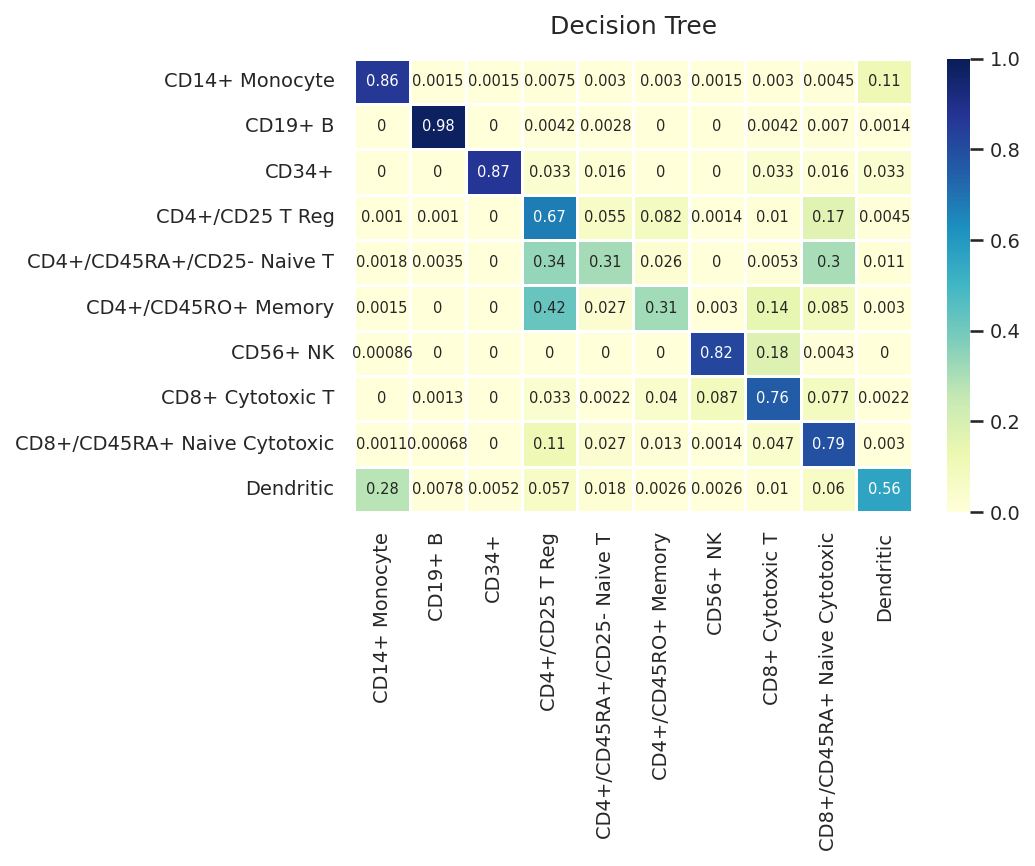

In [11]:
#confusion matrix  
dt_confusion_mtx = confusion_mtx_plotter(dt_pred,"Decision Tree")
dt_confusion_mtx

## Random Forest

In [12]:
rf_grid = {'model__n_estimators': [50,100,500,1000],
           'model__max_features': ["sqrt", "log2", None],
           'model__max_depth': [None,5,10,50,100],
           'model__min_samples_split': [2, 5, 10],
           'model__min_samples_leaf': [1,2,5],
           'model__criterion' : ["gini","entropy"]}

rf_steps = [('over', SMOTE()), ('model', RandomForestClassifier())]
rf_pipeline = Pipeline(steps=rf_steps)

rf_variants = RandomizedSearchCV(estimator = rf_pipeline, param_distributions = rf_grid, n_iter = 100, cv = 3, random_state=42)
rf_variants.fit(X_train,Y_train)
rf_best_params = rf_variants.best_params_
print(rf_best_params)

{'model__n_estimators': 500, 'model__min_samples_split': 5, 'model__min_samples_leaf': 1, 'model__max_features': 'sqrt', 'model__max_depth': 50, 'model__criterion': 'gini'}


In [13]:
#remove the model__ portion of the parameter name
renamed_rf_best_parameters = convert_parameters(rf_best_params)
print(renamed_rf_best_parameters)

#evaluate the performance of the baseline and optimized model
rf_baseline = model_performance(rf_pipeline,X_train, Y_train, X_test,Y_test)[0]
rf_optimized,rf_pred = model_performance(Pipeline(steps = [('over', SMOTE()), ('model', RandomForestClassifier(**renamed_rf_best_parameters))]),X_train, Y_train, X_test,Y_test)

rf_performance = pd.concat([rf_baseline,rf_optimized], axis = 0,ignore_index = True)
rf_performance = rf_performance.rename(index = {0 : "baseline_RandomForest", 1 : "optimized_RandomForest"})
rf_performance

{'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 50, 'criterion': 'gini'}


,f1_macro,precision_macro,recall_macro,accuracy,AUROC_macro
baseline_RandomForest,0.742091,0.841773,0.716723,0.793757,0.973628
optimized_RandomForest,0.748451,0.844822,0.724800,0.797258,0.976646


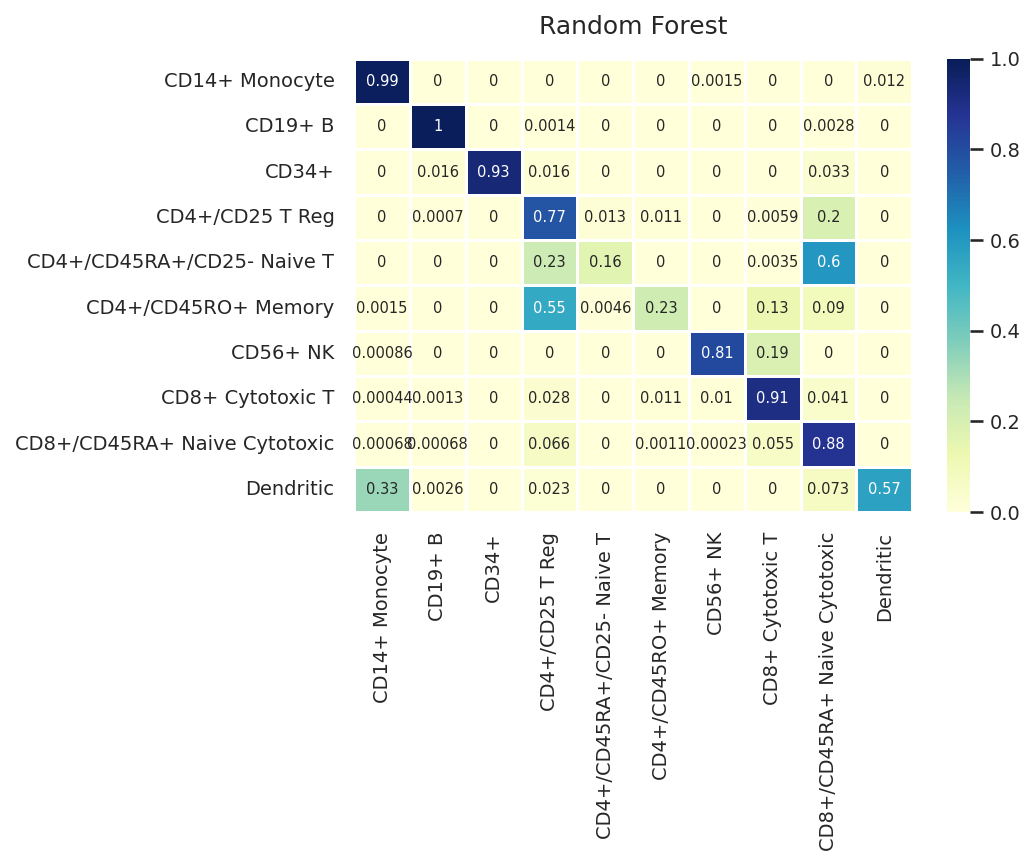

In [14]:
#confusion matrix
rf_confusion_mtx = confusion_mtx_plotter(rf_pred,"Random Forest")
rf_confusion_mtx

## XGBoost

In [15]:
xgb_grid = {'model__objective' : ["multi:softmax"],
            'model__num_class' : [10],
            'model__n_estimators' : [50,100,500,1000],
            'model__max_depth' :[None,5,10,50,100],
            'model__learning_rate' : [0.01,0.1,0.3,1],
            'model__reg_lambda' :[1,2,5],
            'model__reg_alpha' : [0,0.5,1]}
            
xgb_steps = [('over', SMOTE()), ('model', xgb.XGBClassifier())]
xgb_pipeline = Pipeline(steps=xgb_steps)

xgb_variants = RandomizedSearchCV(estimator = xgb_pipeline, param_distributions = xgb_grid, n_iter = 100, cv = 3, random_state=42)
xgb_variants.fit(X_train,Y_train)
xgb_best_params = xgb_variants.best_params_
print(xgb_best_params)

{'model__reg_lambda': 1, 'model__reg_alpha': 0, 'model__objective': 'multi:softmax', 'model__num_class': 10, 'model__n_estimators': 1000, 'model__max_depth': 10, 'model__learning_rate': 0.3}


In [16]:
#remove the model__ portion of the parameter name
renamed_xgb_best_parameters = convert_parameters(xgb_best_params)
print(renamed_xgb_best_parameters)

#evaluate the performance of the baseline and optimized model
xgb_baseline = model_performance(xgb_pipeline,X_train, Y_train, X_test,Y_test)[0]
xgb_optimized,xgb_pred = model_performance(Pipeline(steps = [('over', SMOTE()), ('model', xgb.XGBClassifier(**renamed_xgb_best_parameters))]),X_train, Y_train, X_test,Y_test)

xgb_performance = pd.concat([xgb_baseline,xgb_optimized], axis = 0,ignore_index = True)
xgb_performance = xgb_performance.rename(index = {0 : "baseline_XGBClassifier", 1 : "optimized_XGBClassifier"})
xgb_performance

{'reg_lambda': 1, 'reg_alpha': 0, 'objective': 'multi:softmax', 'num_class': 10, 'n_estimators': 1000, 'max_depth': 10, 'learning_rate': 0.3}


,f1_macro,precision_macro,recall_macro,accuracy,AUROC_macro
baseline_XGBClassifier,0.827590,0.870285,0.801721,0.855528,0.986610
optimized_XGBClassifier,0.842793,0.881901,0.817243,0.877917,0.989023


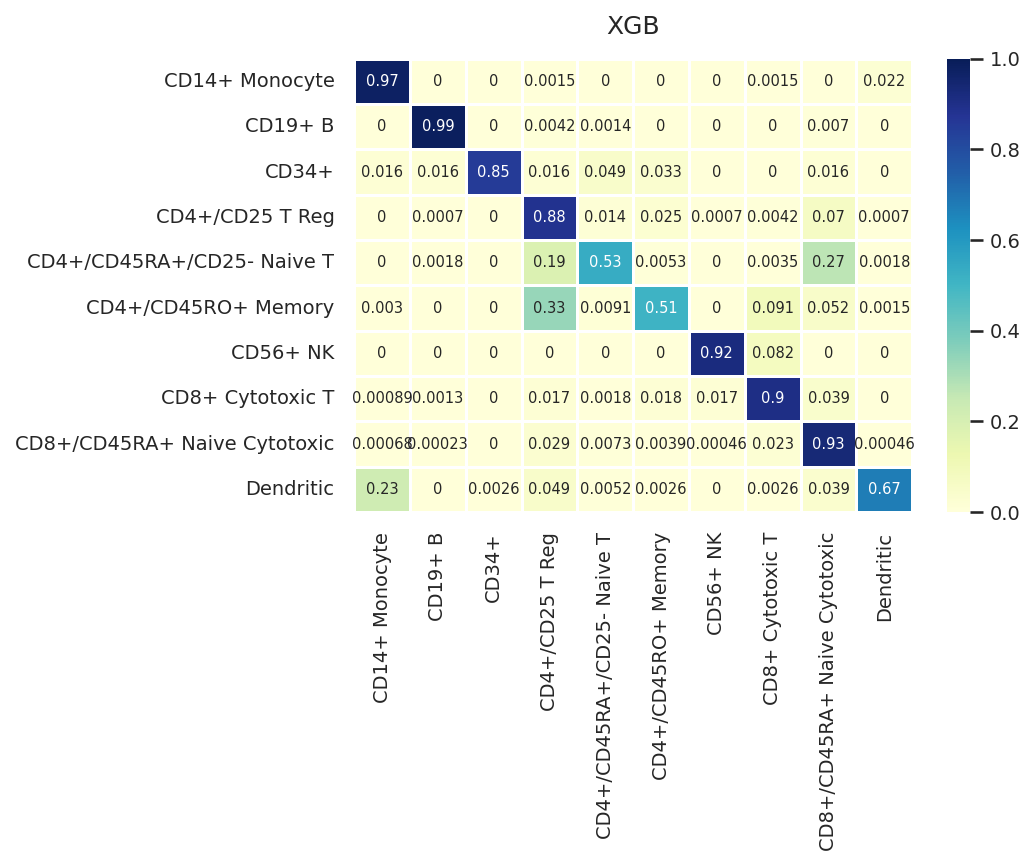

In [17]:
#confusion matrix
xgb_confusion_mtx = confusion_mtx_plotter(xgb_pred,"XGB")
xgb_confusion_mtx

## Logistic Regression

In [18]:
lr_grid = {'model__penalty': ["l1", "l2", "elasticnet", "none"],
           'model__C': [0.1,0.3,0.5,1,2],
           'model__fit_intercept': [True, False],
           'model__dual': [True,False],
           'model__solver': ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
           'model__max_iter' : [50,100,200,500,1000]}

lr_steps = [('over', SMOTE()), ('model', LogisticRegression())]
lr_pipeline = Pipeline(steps=lr_steps)

lr_variants = RandomizedSearchCV(estimator = lr_pipeline, param_distributions = lr_grid, n_iter = 100, cv = 3, random_state=42, n_jobs = -1)
lr_variants.fit(X_train,Y_train)
lr_best_params = lr_variants.best_params_
print(lr_best_params)

{'model__solver': 'sag', 'model__penalty': 'none', 'model__max_iter': 500, 'model__fit_intercept': True, 'model__dual': False, 'model__C': 0.5}


In [19]:
#remove the model__ portion of the parameter name
renamed_lr_best_parameters = convert_parameters(lr_best_params)
print(renamed_lr_best_parameters)

#evaluate the performance of the baseline and optimized model
lr_baseline = model_performance(lr_pipeline,X_train, Y_train, X_test,Y_test)[0]
lr_optimized,lr_pred = model_performance(Pipeline(steps = [('over', SMOTE()), ('model', LogisticRegression(**renamed_lr_best_parameters))]),X_train, Y_train, X_test,Y_test)

lr_performance = pd.concat([lr_baseline,lr_optimized], axis = 0,ignore_index = True)
lr_performance = lr_performance.rename(index = {0 : "baseline_LogisticRegression", 1 : "optimized_LogisticRegression"})
lr_performance

{'solver': 'sag', 'penalty': 'none', 'max_iter': 500, 'fit_intercept': True, 'dual': False, 'C': 0.5}


,f1_macro,precision_macro,recall_macro,accuracy,AUROC_macro
baseline_LogisticRegression,0.855727,0.832747,0.891134,0.862894,0.988530
optimized_LogisticRegression,0.920333,0.920492,0.922157,0.931228,0.995052


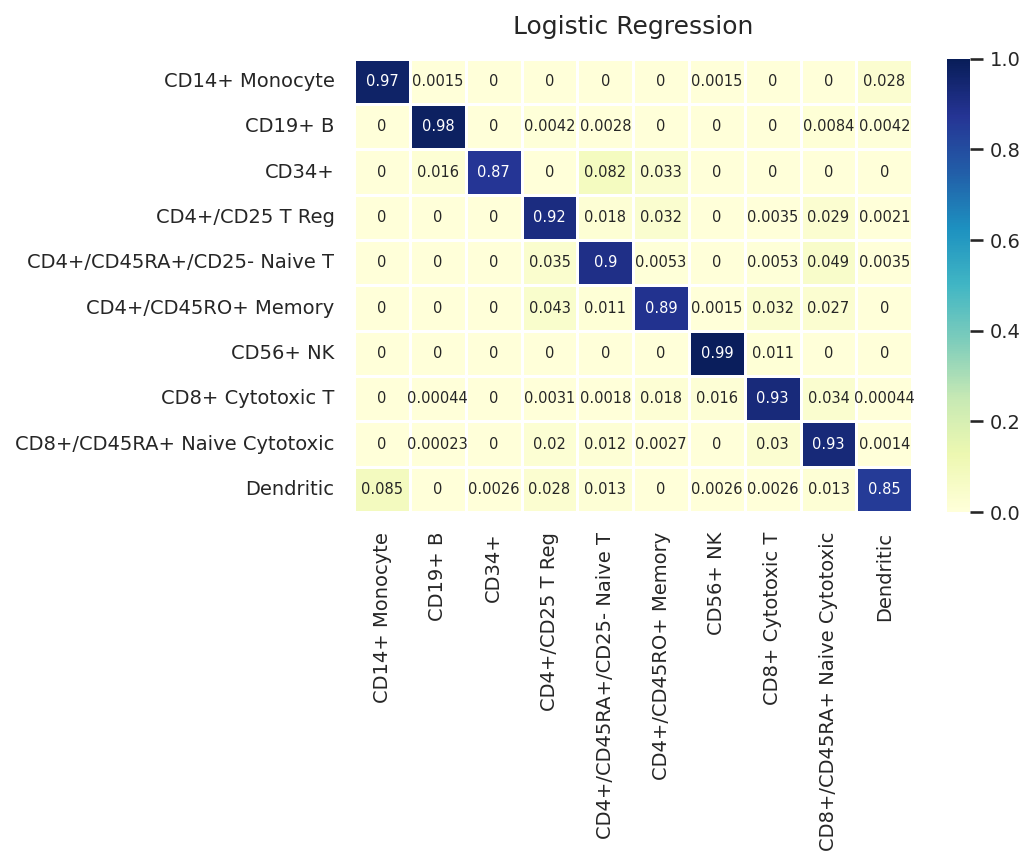

In [20]:
#confusion matrix
lr_confusion_mtx = confusion_mtx_plotter(lr_pred,"Logistic Regression")
lr_confusion_mtx

## MLP

In [21]:
mlp_grid = {'model__hidden_layer_sizes': [(20,),(50,),(100,),(200,)],
            'model__max_iter' : [50,100,200,500,1000],
            'model__activation': ["identity", "logistic", "tanh", "relu"],
            'model__solver': ["lbfgs", "sgd", "adam"],
            'model__alpha': [0.00001,0.0001,0.001,0.01],
            'model__learning_rate': ["constant", "invscaling", "adaptive"],
            'model__momentum' : [0.1, 0.5, 0.9]}

mlp_steps = [('over', SMOTE()), ('model', MLPClassifier())]
mlp_pipeline = Pipeline(steps=mlp_steps)

mlp_variants = RandomizedSearchCV(estimator = mlp_pipeline, param_distributions = mlp_grid, n_iter = 100, cv = 3, random_state=42, n_jobs = -1)
mlp_variants.fit(X_train,Y_train)
mlp_best_params = mlp_variants.best_params_
print(mlp_best_params)

{'model__solver': 'lbfgs', 'model__momentum': 0.1, 'model__max_iter': 1000, 'model__learning_rate': 'adaptive', 'model__hidden_layer_sizes': (20,), 'model__alpha': 0.01, 'model__activation': 'relu'}


In [22]:
#remove the model__ portion of the parameter name
renamed_mlp_best_parameters = convert_parameters(mlp_best_params)
print(renamed_mlp_best_parameters)

#evaluate the performance of the baseline and optimized model
mlp_baseline = model_performance(mlp_pipeline,X_train, Y_train, X_test,Y_test)[0]
mlp_optimized,mlp_pred = model_performance(Pipeline(steps = [('over', SMOTE()), ('model', MLPClassifier(**renamed_mlp_best_parameters))]),X_train, Y_train, X_test,Y_test)

mlp_performance = pd.concat([mlp_baseline,mlp_optimized], axis = 0,ignore_index = True)
mlp_performance = mlp_performance.rename(index = {0 : "baseline_MLP", 1 : "optimized_MLP"})
mlp_performance

{'solver': 'lbfgs', 'momentum': 0.1, 'max_iter': 1000, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (20,), 'alpha': 0.01, 'activation': 'relu'}


,f1_macro,precision_macro,recall_macro,accuracy,AUROC_macro
baseline_MLP,0.910058,0.922291,0.899184,0.932468,0.995729
optimized_MLP,0.924412,0.924085,0.925882,0.942532,0.996104


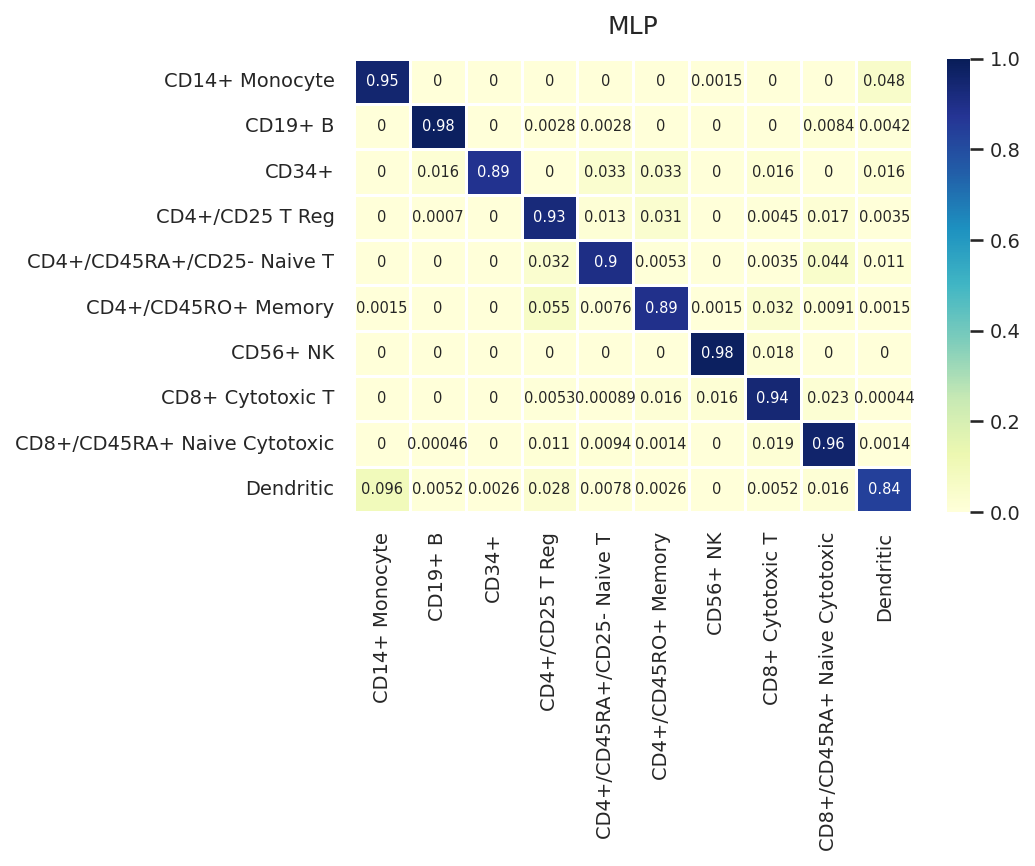

In [23]:
#confusion matrix
mlp_confusion_mtx = confusion_mtx_plotter(mlp_pred,"MLP")
mlp_confusion_mtx

## Comparing all models optimized performance

In [24]:
overall_performance = pd.concat([knn_performance, dt_performance, rf_performance, xgb_performance, lr_performance, mlp_performance])
optimized_performance = overall_performance.iloc[[1,3,5,7,9,11]]
optimized_performance

,f1_macro,precision_macro,recall_macro,accuracy,AUROC_macro
optimized_KNN,0.644286,0.663485,0.636579,0.663288,0.912891
optimized_DecisionTree,0.701464,0.710925,0.693564,0.728121,0.872015
optimized_RandomForest,0.748451,0.844822,0.724800,0.797258,0.976646
optimized_XGBClassifier,0.842793,0.881901,0.817243,0.877917,0.989023
optimized_LogisticRegression,0.920333,0.920492,0.922157,0.931228,0.995052
optimized_MLP,0.924412,0.924085,0.925882,0.942532,0.996104


In [25]:
mpl.rcParams.update(mpl.rcParamsDefault)

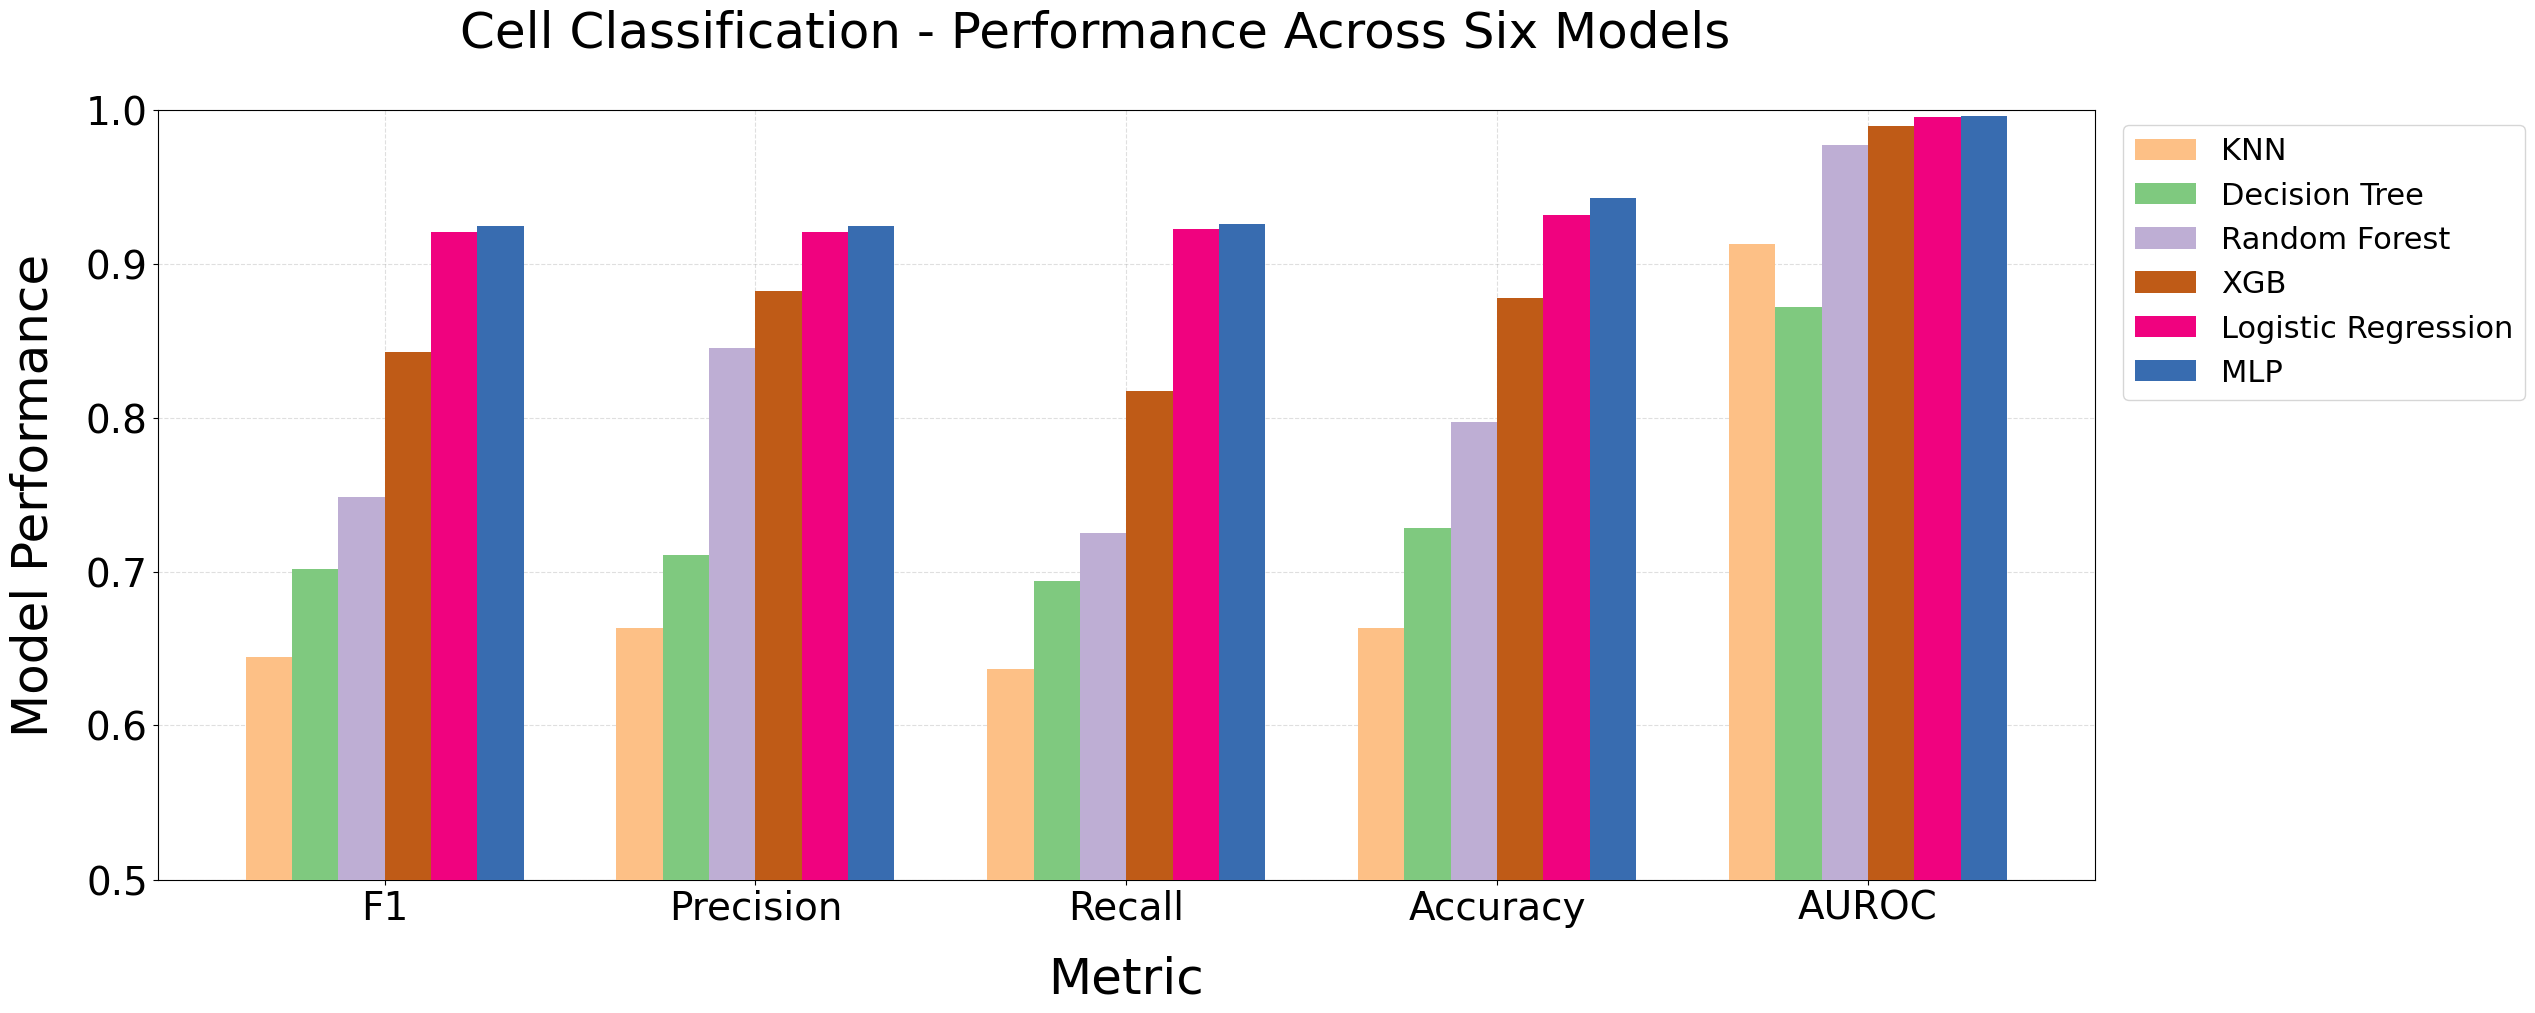

In [29]:
ind = np.arange(5)
fig, ax = plt.subplots(figsize = (25, 10))

knn_bar = ax.bar(ind - 0.3125, optimized_performance.iloc[0], alpha=1, width = 0.125, color = '#fdc086', align = 'center', zorder = 3)
dt_bar = ax.bar(ind - 0.1875, optimized_performance.iloc[1], alpha=1, width = 0.125, color = '#7fc97f', align = 'center', zorder = 3)
rf_bar = ax.bar(ind - 0.0625, optimized_performance.iloc[2], alpha=1, width = 0.125, color = '#beaed4', align = 'center', zorder = 3)
xgb_bar = ax.bar(ind + 0.0625, optimized_performance.iloc[3], alpha = 1, width = 0.125, color = '#bf5b17' , align = 'center', zorder = 3)
lr_bar = ax.bar(ind + 0.1875, optimized_performance.iloc[4], alpha=1, width = 0.125, color = '#f0027f', align = 'center', zorder = 3)
mlp_bar = ax.bar(ind + 0.3125, optimized_performance.iloc[5], alpha=1, width = 0.125, color = '#386cb0', align = 'center', zorder = 3)

ax.set_ylabel("Model Performance", size = 36)
ax.set_xlabel("Metric", size = 36)
ax.set_ylim([0.5,1])
ax.set_xticks(ind, labels = ['F1','Precision','Recall','Accuracy','AUROC'])
ax.tick_params(axis='both', labelsize=28, direction = 'out',colors = 'black')
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20
ax.legend((knn_bar[0],dt_bar[0], rf_bar[0], xgb_bar[0], lr_bar[0],mlp_bar[0]), ('KNN','Decision Tree','Random Forest', 'XGB','Logistic Regression','MLP'),prop={'size': 22}, bbox_to_anchor=(1.23, 1), loc='upper right')
ax.grid(True,which = 'major',alpha = 0.4,linestyle ='--',zorder = 0)
fig.suptitle('Cell Classification - Performance Across Six Models', fontsize=36)

plt.savefig('Performance_six_models.png',dpi = 600,bbox_inches='tight')